# Подготовка данных

### Проверка и установка рабочей директории, должен быть корень проекта

In [1]:
%pwd

'C:\\Users\\Kuroha\\source\\repos_py\\bauman_final_project\\notebooks'

In [2]:
%cd ..

C:\Users\Kuroha\source\repos_py\bauman_final_project


### Загрузка датасетов:

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import *

In [4]:
def open_dataset(dataset_name):
    path = get_filepath(dataset_name, is_raw=True)
    return pd.read_csv(path, index_col = ['uid', 'date'], parse_dates=['date'])

weather_df = open_dataset(DATA_WEATHER)
weather_target_df = open_dataset(DATA_WEATHER_TARGET)
water_lvl_df = open_dataset(DATA_WATER_LEVEL)

### Информация о датасетах:

#### water_level

В датасете представлены замеры уровня воды для постов гидрологического контроля с сайта АИС ГМВО.

In [5]:
weather_df.head()

temperature  pressure  cloud weather wind_dir  wind_spd
uid  date                                                               
9386 2008-01-01        -17.0     735.0   dull    snow       ЮЗ       2.0
     2008-01-02        -31.0     747.0    sun   clear       СЗ       2.0
     2008-01-03        -43.0     753.0    sun   clear        З       2.0
     2008-01-04        -34.0     733.0   dull    snow        Ш       0.0
     2008-01-05        -28.0     728.0  suncl   clear        З       1.0

In [6]:
water_lvl_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 98263 entries, (9386, Timestamp('2008-01-01 00:00:00')) to (9568, Timestamp('2017-12-31 00:00:00'))
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   water_level  98263 non-null  int64
dtypes: int64(1)
memory usage: 1.2 MB


In [7]:
water_lvl_df.columns

Index(['water_level'], dtype='object')

In [8]:
water_lvl_df.shape

(98263, 1)

#### weather

В **weather** содержится погода на период 2008-2017 для обучения моделей.  
В датасетах **weather** и **weather_test** с данными метеосводок Gismeteo есть следующие столбцы:
- индекс **uid** - идентификационный номер поста гидрологического контроля с сайта АИС ГМВО.
- индекс **date** - дата замера
- **temperature** - температура
- **pressure** - атмосферное давление
- **cloud** - облачность
- **weather** - погодное явление
- **wind_dir** - направление ветра
- **wind_spd** - скорость ветра в м/с

In [9]:
weather_df.head(5)

temperature  pressure  cloud weather wind_dir  wind_spd
uid  date                                                               
9386 2008-01-01        -17.0     735.0   dull    snow       ЮЗ       2.0
     2008-01-02        -31.0     747.0    sun   clear       СЗ       2.0
     2008-01-03        -43.0     753.0    sun   clear        З       2.0
     2008-01-04        -34.0     733.0   dull    snow        Ш       0.0
     2008-01-05        -28.0     728.0  suncl   clear        З       1.0

In [10]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102072 entries, (9386, Timestamp('2008-01-01 00:00:00')) to (9518, Timestamp('2017-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  101236 non-null  float64
 1   pressure     101236 non-null  float64
 2   cloud        100924 non-null  object 
 3   weather      101236 non-null  object 
 4   wind_dir     101236 non-null  object 
 5   wind_spd     101236 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.1+ MB


In [11]:
weather_df.columns

Index(['temperature', 'pressure', 'cloud', 'weather', 'wind_dir', 'wind_spd'], dtype='object')

In [12]:
weather_df.shape

(102072, 6)

#### weather_target

В **weather_target** представлена погода на 2018 год для предсказывания.

In [13]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102072 entries, (9386, Timestamp('2008-01-01 00:00:00')) to (9518, Timestamp('2017-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  101236 non-null  float64
 1   pressure     101236 non-null  float64
 2   cloud        100924 non-null  object 
 3   weather      101236 non-null  object 
 4   wind_dir     101236 non-null  object 
 5   wind_spd     101236 non-null  float64
dtypes: float64(3), object(3)
memory usage: 5.1+ MB


In [14]:
weather_target_df.head()

temperature  pressure cloud weather wind_dir  wind_spd
uid  date                                                              
9386 2018-01-01        -26.0     760.0  dull   clear        Ю       1.0
     2018-01-02        -20.0     758.0  dull    snow       ЮЗ       3.0
     2018-01-03        -13.0     753.0   sun   clear       ЮЗ       2.0
     2018-01-04        -12.0     749.0  sunc   clear       ЮЗ       2.0
     2018-01-05        -10.0     742.0  dull    snow        З       2.0

In [15]:
weather_target_df.shape

(10220, 6)

### Объединение тренировочных наборов данных:

In [16]:
df = weather_df.join(water_lvl_df)
df.head(), df.info(), df.shape, weather_df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 102072 entries, (9386, Timestamp('2008-01-01 00:00:00')) to (9518, Timestamp('2017-12-31 00:00:00'))
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   temperature  101236 non-null  float64
 1   pressure     101236 non-null  float64
 2   cloud        100924 non-null  object 
 3   weather      101236 non-null  object 
 4   wind_dir     101236 non-null  object 
 5   wind_spd     101236 non-null  float64
 6   water_level  98065 non-null   float64
dtypes: float64(4), object(3)
memory usage: 9.9+ MB


(                 temperature  pressure  cloud weather wind_dir  wind_spd  \
 uid  date                                                                  
 9386 2008-01-01        -17.0     735.0   dull    snow       ЮЗ       2.0   
      2008-01-02        -31.0     747.0    sun   clear       СЗ       2.0   
      2008-01-03        -43.0     753.0    sun   clear        З       2.0   
      2008-01-04        -34.0     733.0   dull    snow        Ш       0.0   
      2008-01-05        -28.0     728.0  suncl   clear        З       1.0   
 
                  water_level  
 uid  date                     
 9386 2008-01-01        138.0  
      2008-01-02        138.0  
      2008-01-03        138.0  
      2008-01-04        138.0  
      2008-01-05        138.0  ,
 None,
 (102072, 7),
 (102072, 6))

Количество строк до объединения **weather_df** и после осталось тем же.

### Работа с пропусками:

In [17]:
print(f'Размерность water_lvl_df: {water_lvl_df.shape}')
print(f'Размерность weather_df: {weather_df.shape}')
print(f'Размерность df: {df.shape}')
print(f'Размерность weather_target_df: {weather_target_df.shape}')

Размерность water_lvl_df: (98263, 1)
Размерность weather_df: (102072, 6)
Размерность df: (102072, 7)
Размерность weather_target_df: (10220, 6)


В датасете **weather_df** есть строки за каждый день по каждому посту, однако в данных есть пропуски:

In [18]:
df[df.isnull().any(axis=1)]

temperature  pressure cloud weather wind_dir  wind_spd  \
uid  date                                                                 
9386 2011-06-19          NaN       NaN   NaN     NaN      NaN       NaN   
     2012-02-06          NaN       NaN   NaN     NaN      NaN       NaN   
     2013-11-10          1.0     743.0  sunc   clear        З       4.0   
     2013-11-11         -3.0     740.0  dull    snow       ЮЗ       4.0   
     2013-11-12         -7.0     739.0  sunc   clear        З       4.0   
...                      ...       ...   ...     ...      ...       ...   
9518 2016-09-20         10.0     730.0   NaN   clear       ЮЗ       1.0   
     2016-09-28         11.0     728.0   NaN   clear       ЮЗ       2.0   
     2017-08-14         28.0     729.0   NaN   clear       ЮЗ       3.0   
     2017-11-26          NaN       NaN   NaN     NaN      NaN       NaN   
     2017-11-27          NaN       NaN   NaN     NaN      NaN       NaN   

                 water_level  
uid  date                     
9386 2011-06-19        137.0  
     2012-02-06        129.0  
     2013-11-10          NaN  
     2013-11-11          NaN  
     2013-11-12          NaN  
...                      ...  
9518 2016-09-20         79.0  
     2016-09-28         79.0  
     2017-08-14         63.0  
     2017-11-26         81.0  
     2017-11-27         80.0  

[5094 rows x 7 columns]

Рассмотрим данные с поста 9518 за период с 2017-11-25 по 2017-11-28, где отсутствуют метео-данные:

In [19]:
test_start_date = '2017-11-25'
test_end_date   = '2017-11-28'
df.query('uid == 9518 and date >= @test_start_date and date <= @test_end_date')

temperature  pressure cloud weather wind_dir  wind_spd  \
uid  date                                                                 
9518 2017-11-25        -35.0     741.0  sunc   clear        Ю       2.0   
     2017-11-26          NaN       NaN   NaN     NaN      NaN       NaN   
     2017-11-27          NaN       NaN   NaN     NaN      NaN       NaN   
     2017-11-28        -33.0     749.0   sun   clear        Ш       0.0   

                 water_level  
uid  date                     
9518 2017-11-25         81.0  
     2017-11-26         81.0  
     2017-11-27         80.0  
     2017-11-28         80.0

In [20]:
df.isnull().sum()

temperature     836
pressure        836
cloud          1148
weather         836
wind_dir        836
wind_spd        836
water_level    4007
dtype: int64

Уберём всё строки с отсутствующими данными:

In [21]:
df.shape

(102072, 7)

In [22]:
print(f'Процент строк с отсутствующими метео-данными: {df["temperature"].isnull().sum() / df.shape[0] * 100:.2f}%')
print(f'Процент строк с отсутствующими данными об уровне воды: {df["water_level"].isnull().sum() / df.shape[0] * 100:.2f}%')

Процент строк с отсутствующими метео-данными: 0.82%
Процент строк с отсутствующими данными об уровне воды: 3.93%


In [23]:
df = df.dropna()  # 6 - число столбцов у метео-данных
df.shape

(96978, 7)

In [24]:
df.isnull().sum()

temperature    0
pressure       0
cloud          0
weather        0
wind_dir       0
wind_spd       0
water_level    0
dtype: int64

Чтобы в дальнейшем работать с текущими значениями внутри мультииндекса (uid и дата замера), создадим столбец с новым индексом:

In [25]:
df.reset_index(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96978 entries, 0 to 96977
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          96978 non-null  int64         
 1   date         96978 non-null  datetime64[ns]
 2   temperature  96978 non-null  float64       
 3   pressure     96978 non-null  float64       
 4   cloud        96978 non-null  object        
 5   weather      96978 non-null  object        
 6   wind_dir     96978 non-null  object        
 7   wind_spd     96978 non-null  float64       
 8   water_level  96978 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 6.7+ MB


### Обработка категориальных признаков:

#### Cloud (облачность):

In [26]:
def print_col_info(column):
    print(f'''describe:
{column.describe(datetime_is_numeric=True)}
{"-" * 80}
unique:
{column.unique()}
{"-" * 80}
nunique:
{column.nunique()}
{"-" * 80}
value_count:
{column.value_counts()}''')

print_col_info(df['cloud'])

describe:
count     96978
unique        4
top        dull
freq      36815
Name: cloud, dtype: object
--------------------------------------------------------------------------------
unique:
['dull' 'sun' 'suncl' 'sunc']
--------------------------------------------------------------------------------
nunique:
4
--------------------------------------------------------------------------------
value_count:
dull     36815
suncl    22134
sun      20091
sunc     17938
Name: cloud, dtype: int64


Облачность может быть следующей:
- **sun** - ясно
- **sunс** - малооблачно
- **suncl** - облачно
- **dull** - пасмурно

Здесь прослеживается порядок - от ясного неба к пасмурному, поэтому для кодирования данного упорядоченного признака необходимо использовать метод Label Encoder.

Реализация данного метода в sklearn перед кодированием [сортирует уникальные признаки в алфавитном порядке](https://github.com/scikit-learn/scikit-learn/blob/f3f51f9b611bf873bd5836748647221480071a87/sklearn/preprocessing/_label.py#L799), в результате чего будет нарушен порядок: **dull** будет закодирован как 0, **sun** - как 1, **sunс** - 2, **suncl** - 3.

In [27]:
df['cloud'] = df['cloud'].map({'sun': 0, 'sunc': 1, 'suncl': 2, 'dull': 3})
df.head(5)

,uid,date,temperature,pressure,cloud,weather,wind_dir,wind_spd,water_level
0,9386,2008-01-01,-17.0,735.0,3,snow,ЮЗ,2.0,138.0
1,9386,2008-01-02,-31.0,747.0,0,clear,СЗ,2.0,138.0
2,9386,2008-01-03,-43.0,753.0,0,clear,З,2.0,138.0
3,9386,2008-01-04,-34.0,733.0,3,snow,Ш,0.0,138.0
4,9386,2008-01-05,-28.0,728.0,2,clear,З,1.0,138.0


#### uid:

In [28]:
print_col_info(df['uid'])

describe:
count    96978.000000
mean      9427.083586
std         52.220990
min       9386.000000
25%       9393.000000
50%       9408.000000
75%       9420.000000
max       9568.000000
Name: uid, dtype: float64
--------------------------------------------------------------------------------
unique:
[9386 9387 9388 9389 9390 9392 9393 9396 9397 9499 9523 9560 9568 9403
 9404 9405 9406 9408 9410 9413 9415 9416 9417 9419 9420 9421 9422 9518]
--------------------------------------------------------------------------------
nunique:
28
--------------------------------------------------------------------------------
value_count:
9405    3648
9389    3629
9416    3628
9568    3622
9415    3621
9417    3607
9499    3607
9403    3604
9397    3602
9518    3599
9404    3593
9406    3586
9387    3585
9410    3582
9420    3582
9408    3580
9422    3570
9392    3569
9386    3564
9393    3560
9388    3554
9390    3552
9419    3552
9523    3538
9396    3532
9413    3356
9560    3213
9421     743
Name:

Представляет собой идентификационный номер поста гидрологического контроля в базе данных сайта АИС ГМВО.

Задачу прогнозирования можно решить двумя способами:
1. Разработать одну модель для всех постов. Это имеет смысл, т.к. посты географически расположены близко друг к другу, а также замеряют уровень воды одной реки.
2. Разработать индивидуальные модели для всех постов.
    
Будет реализовано оба варианта, затем будет выбран наиболее точный вариант.

Для первого варианта необходимо закодировать uid как категориальные данные, используя One Hot Encoding:

In [29]:
def encode_uid(df_target):
    encoder = OneHotEncoder()
    df_uid = pd.DataFrame(encoder.fit_transform(df[['uid']]).toarray())
    df_uid = df_uid.add_prefix('uid_')  # префикс для визуального определения признака
    df_uid = df_uid.astype('category')  # конвертация в категориальный тип данных
    return df_target.join(df_uid)

df = encode_uid(df)
df.head(2)

,uid,date,temperature,pressure,cloud,weather,wind_dir,wind_spd,water_level,uid_0,...,uid_18,uid_19,uid_20,uid_21,uid_22,uid_23,uid_24,uid_25,uid_26,uid_27
0,9386,2008-01-01,-17.0,735.0,3,snow,ЮЗ,2.0,138.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9386,2008-01-02,-31.0,747.0,0,clear,СЗ,2.0,138.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96978 entries, 0 to 96977
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   uid          96978 non-null  int64         
 1   date         96978 non-null  datetime64[ns]
 2   temperature  96978 non-null  float64       
 3   pressure     96978 non-null  float64       
 4   cloud        96978 non-null  int64         
 5   weather      96978 non-null  object        
 6   wind_dir     96978 non-null  object        
 7   wind_spd     96978 non-null  float64       
 8   water_level  96978 non-null  float64       
 9   uid_0        96978 non-null  category      
 10  uid_1        96978 non-null  category      
 11  uid_2        96978 non-null  category      
 12  uid_3        96978 non-null  category      
 13  uid_4        96978 non-null  category      
 14  uid_5        96978 non-null  category      
 15  uid_6        96978 non-null  category      
 16  uid_

#### Date (дата):

In [31]:
print_col_info(df['date'])

describe:
count                            96978
mean     2012-12-12 09:02:30.788838656
min                2008-01-01 00:00:00
25%                2010-06-10 00:00:00
50%                2012-12-03 00:00:00
75%                2015-05-29 00:00:00
max                2017-12-31 00:00:00
Name: date, dtype: object
--------------------------------------------------------------------------------
unique:
['2008-01-01T00:00:00.000000000' '2008-01-02T00:00:00.000000000'
 '2008-01-03T00:00:00.000000000' ... '2015-10-07T00:00:00.000000000'
 '2015-11-15T00:00:00.000000000' '2015-11-18T00:00:00.000000000']
--------------------------------------------------------------------------------
nunique:
3648
--------------------------------------------------------------------------------
value_count:
2010-05-05    28
2013-05-25    28
2013-05-17    28
2013-05-18    28
2013-05-19    28
              ..
2015-09-21     6
2015-09-20     6
2015-09-18     6
2015-09-17     6
2015-11-18     3
Name: date, Length: 3648, 

Представляет собой день наблюдений. Данное значение можно закодировать как:
1. Год - категориальный признак, используя метод Label Encoder (есть порядок: 2008 год был раньше, чем 2017)
2. Номер дня в году - цикличный признак.

Значения дня представляет собой следующий график:

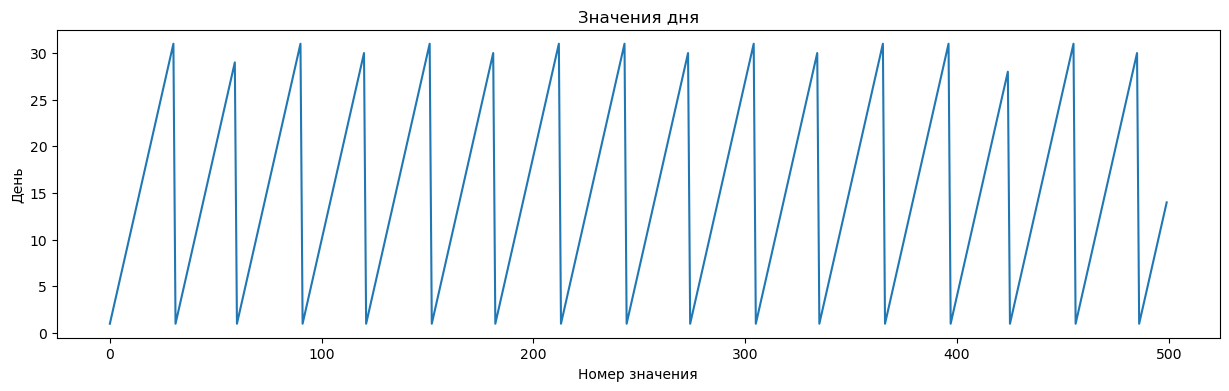

In [32]:
plt.figure(figsize=(15, 4))
plt.plot(df['date'].dt.day[:500])
plt.xlabel('Номер значения')
plt.ylabel('День')
plt.title('Значения дня')

plt.show()

Данные являются зацикленными, т.к. 31 день в месяце отличается от следующего 1-го дня лишь на одну единицу, а не на 30. Значение дня в году [можно представить в виде двух функций](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html):

$x_{sin} = \sin(\frac{2 * \pi * x}{\max(x)})$

$x_{cos} = \cos(\frac{2 * \pi * x}{\max(x)})$

In [33]:
test_day = 70
np.sin(2 * np.pi * test_day/365.0), np.cos(2 * np.pi * test_day/365.0)

(0.9338372288229252, 0.35769823883312546)

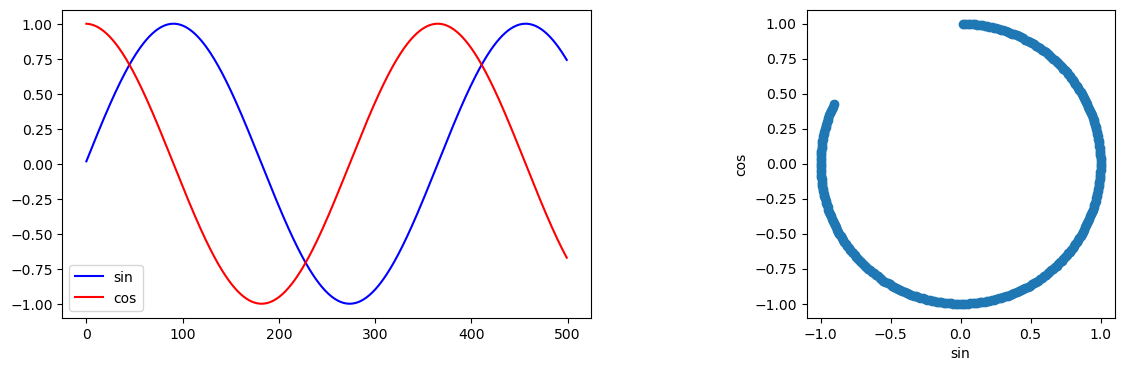

In [34]:
test_df = df[0:500]['date']
total_years = np.where(test_df.dt.is_leap_year, 366, 365)
test_arr = test_df.dt.dayofyear
test_sin = np.sin(2 * np.pi * test_arr / total_years)
test_cos = np.cos(2 * np.pi * test_arr / total_years)

fig = plt.figure(figsize=(15, 4))

ax1 = fig.add_subplot(121)
ax1.plot(test_sin, color='blue', label='sin')
ax1.plot(test_cos, color='red', label='cos')
ax1.legend()


# показ точек на графике за 300 дней

ax2 = fig.add_subplot(122)
ax2.set_aspect('equal')
ax2.scatter(test_sin[:300], test_cos[:300])
ax2.set_xlabel('sin')
ax2.set_ylabel('cos')

plt.show()

Закодируем год и номер дня в году:

In [35]:
total_years = np.where(df['date'].dt.is_leap_year, 366, 365)
df['year'] = df['date'].dt.year
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / total_years)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / total_years)
df[['date', 'year', 'day_sin', 'day_cos']].head()

,date,year,day_sin,day_cos
0,2008-01-01,2008,0.017166,0.999853
1,2008-01-02,2008,0.034328,0.999411
2,2008-01-03,2008,0.051479,0.998674
3,2008-01-04,2008,0.068615,0.997643
4,2008-01-05,2008,0.085731,0.996318


In [36]:
df['year'].value_counts().sort_index()

2008    10063
2009     9831
2010     9949
2011     9513
2012     9892
2013     9585
2014     9878
2015     8974
2016     9664
2017     9629
Name: year, dtype: int64

#### Weather (осадки)

In [37]:
print_col_info(df['weather'])

describe:
count     96978
unique        4
top       clear
freq      74268
Name: weather, dtype: object
--------------------------------------------------------------------------------
unique:
['snow' 'clear' 'rain' 'storm']
--------------------------------------------------------------------------------
nunique:
4
--------------------------------------------------------------------------------
value_count:
clear    74268
snow     16326
rain      5720
storm      664
Name: weather, dtype: int64


Под осадками может пониматься следующее:
- **clear** - осадков не было
- **rain** - дождь
- **storm** - гроза
- **snow** - снег

Данный признак можно закодировать разными способами:
1. Выделение признака **наличие осадков**: и дождь, и снег образовываются из капель воды, а грозы, как правило, сопровождаются сильным дождём;
2. Объединение понятий "гроза" и "дождь", выделив 2 признака: **дождь** и **снег**;
3. 3 признака: **дождь**, **гроза**, **снег**, т.к. бывают сухие грозы.

Во всех случаях отсутствие осадков обозначается 0 во всех признаках.

In [38]:
df['weather_v1_precip'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 1, 'snow': 1})

df['weather_v2_rain'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 1, 'snow': 0})

# снег одинаково обозначается во 2 и 3 случаях
df['weather_snow'] = df['weather'].map({'clear': 0, 'rain': 0, 'storm': 0, 'snow': 1})

df['weather_v3_rain'] = df['weather'].map({'clear': 0, 'rain': 1, 'storm': 0, 'snow': 0})
df['weather_v3_storm'] = df['weather'].map({'clear': 0, 'rain': 0, 'storm': 1, 'snow': 0})

df = df.drop(['weather'], axis=1)
df.head()

,uid,date,temperature,pressure,cloud,wind_dir,wind_spd,water_level,uid_0,uid_1,...,uid_26,uid_27,year,day_sin,day_cos,weather_v1_precip,weather_v2_rain,weather_snow,weather_v3_rain,weather_v3_storm
0,9386,2008-01-01,-17.0,735.0,3,ЮЗ,2.0,138.0,1.0,0.0,...,0.0,0.0,2008,0.017166,0.999853,1,0,1,0,0
1,9386,2008-01-02,-31.0,747.0,0,СЗ,2.0,138.0,1.0,0.0,...,0.0,0.0,2008,0.034328,0.999411,0,0,0,0,0
2,9386,2008-01-03,-43.0,753.0,0,З,2.0,138.0,1.0,0.0,...,0.0,0.0,2008,0.051479,0.998674,0,0,0,0,0
3,9386,2008-01-04,-34.0,733.0,3,Ш,0.0,138.0,1.0,0.0,...,0.0,0.0,2008,0.068615,0.997643,1,0,1,0,0
4,9386,2008-01-05,-28.0,728.0,2,З,1.0,138.0,1.0,0.0,...,0.0,0.0,2008,0.085731,0.996318,0,0,0,0,0


#### Wind_dir (направление ветра)

In [39]:
print_col_info(df['wind_dir'])

describe:
count     96978
unique        9
top           З
freq      15772
Name: wind_dir, dtype: object
--------------------------------------------------------------------------------
unique:
['ЮЗ' 'СЗ' 'З' 'Ш' 'С' 'ЮВ' 'СВ' 'В' 'Ю']
--------------------------------------------------------------------------------
nunique:
9
--------------------------------------------------------------------------------
value_count:
З     15772
Ш     15744
ЮЗ    14843
Ю     12546
СЗ     9108
С      8518
ЮВ     7958
В      7318
СВ     5171
Name: wind_dir, dtype: int64


Направление ветра обозначается как основными сторонами света: **С**евер, **Ю**г, **З**апад, **В**осток, так и промежуточными направлениями: **С**еверо-**З**апад, **С**еверо-**В**осток, **Ю**го-**З**апад, **Ю**го-**В**осток. Отсуствие ветра - **Ш**тиль.
Данный признак можно закодировать 4 столбцами, а именно как стороны света.

In [40]:
values = list(df['wind_dir'].unique())

north_dict = {val:(1 if 'С' in val else 0) for val in values}  # север
south_dict = {val:(1 if 'Ю' in val else 0) for val in values}  # юг
west_dict = {val:(1 if 'З' in val else 0) for val in values}   # запад
east_dict = {val:(1 if 'В' in val else 0) for val in values}   # восток

df['north'] = df['wind_dir'].map(north_dict)
df['south'] = df['wind_dir'].map(south_dict)
df['west'] = df['wind_dir'].map(west_dict)
df['east'] = df['wind_dir'].map(east_dict)

df = df.drop(['wind_dir'], axis=1)
df[['north', 'south', 'west', 'east']].head()

,north,south,west,east
0,0,1,1,0
1,1,0,1,0
2,0,0,1,0
3,0,0,0,0
4,0,0,1,0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96978 entries, 0 to 96977
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   uid                96978 non-null  int64         
 1   date               96978 non-null  datetime64[ns]
 2   temperature        96978 non-null  float64       
 3   pressure           96978 non-null  float64       
 4   cloud              96978 non-null  int64         
 5   wind_spd           96978 non-null  float64       
 6   water_level        96978 non-null  float64       
 7   uid_0              96978 non-null  category      
 8   uid_1              96978 non-null  category      
 9   uid_2              96978 non-null  category      
 10  uid_3              96978 non-null  category      
 11  uid_4              96978 non-null  category      
 12  uid_5              96978 non-null  category      
 13  uid_6              96978 non-null  category      
 14  uid_7 

In [42]:
# конвертируем float в категориальный тип данных для уменьшения использования памяти
for dtype in ['weather_v1_precip', 'weather_snow', 'weather_v2_rain', 
              'weather_v3_rain', 'weather_v3_storm', 'north', 'south', 'west', 'east']:
    df[dtype] = df[dtype].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96978 entries, 0 to 96977
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   uid                96978 non-null  int64         
 1   date               96978 non-null  datetime64[ns]
 2   temperature        96978 non-null  float64       
 3   pressure           96978 non-null  float64       
 4   cloud              96978 non-null  int64         
 5   wind_spd           96978 non-null  float64       
 6   water_level        96978 non-null  float64       
 7   uid_0              96978 non-null  category      
 8   uid_1              96978 non-null  category      
 9   uid_2              96978 non-null  category      
 10  uid_3              96978 non-null  category      
 11  uid_4              96978 non-null  category      
 12  uid_5              96978 non-null  category      
 13  uid_6              96978 non-null  category      
 14  uid_7 

### Визуализация статистики:

Динамика изменения уровня воды:

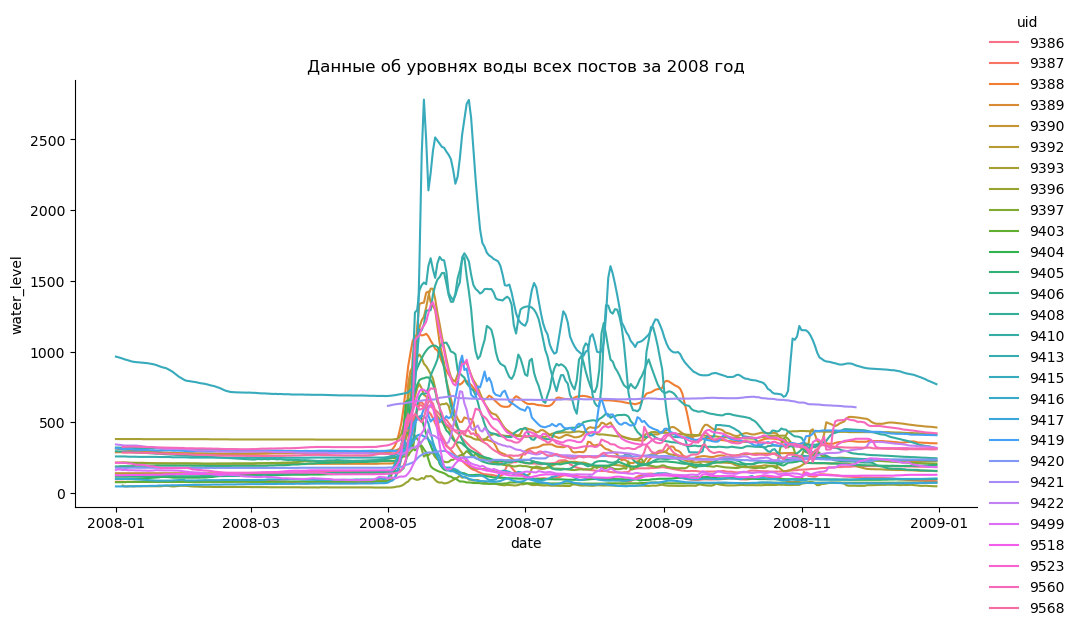

In [43]:
test_df = df[df['date'].dt.year == START_YEAR]

palette = sns.color_palette("husl", 28)
sns.relplot(data=test_df, x='date', y='water_level', palette=palette,
            hue='uid', kind="line", aspect=2, legend='full').set(
                title=f'Данные об уровнях воды всех постов за {START_YEAR} год')

In [ ]:
test_df = df[df['date'].dt.year == END_YEAR]

palette = sns.color_palette("husl", 28)
sns.relplot(data=test_df, x='date', y='water_level', palette=palette,
            hue='uid', kind="line", aspect=2, legend='full').set(
                title=f'Данные об уровнях воды всех постов за {END_YEAR} год')

Не для всех постов есть данные за каждый день, например:

In [ ]:
test_start_date = '2008-01-01'
test_end_date = '2008-12-31'

test_df = df.query('uid == 9421 and date >= @START_YEAR and date <= @test_end_date')
test_df['date'].head(3), test_df['date'].tail(3)

В 2008 году у поста 9421 (руч.без названия - факт.Кербо) есть показания от 1 мая до 25 ноября.

### Работа с аномалиями данных

In [ ]:
df.info()

Рассмотрим зависимости признаков:

In [ ]:
sns.pairplot(df[['temperature', 'pressure', 'wind_spd', 'water_level']], diag_kind='kde')

По графикам видно, что в признаках давления и скорости ветра присутствуют выбросы.

In [ ]:
fig = plt.figure(figsize=(15, 9))

ax1 = fig.add_subplot(221)
sns.boxplot(data=df, x='pressure', ax=ax1).set(title='Давление')

ax2 = fig.add_subplot(222)
sns.boxplot(data=df, x='wind_spd', ax=ax2).set(title='Скорость ветра')

ax3 = fig.add_subplot(223)
sns.histplot(data=df, x='pressure', ax=ax3).set(title='Давление ветра')

ax4 = fig.add_subplot(224)
sns.histplot(data=df, x='wind_spd', ax=ax4).set(title='Скорость ветра')

plt.show()

#### Давление:

In [ ]:
print_col_info(df['pressure'])

In [ ]:
# самые низкие значения
df.sort_values(by='pressure', ascending=True)[['uid', 'date', 'pressure']].head(10)

In [ ]:
# самые высокие значения
df.sort_values(by='pressure', ascending=False)[['uid', 'date', 'pressure']].head(10)

Для определения выбросов найдём значения, которые не находятся в диапазоне между квантилями 0.25 и 0.75:

In [ ]:
def find_boundaries(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

In [ ]:
pressure_lower_bound, pressure_upper_bound = find_boundaries(df['pressure'])
pressure_lower_bound, pressure_upper_bound

In [ ]:
pressure_upper = np.where(df['pressure'] > pressure_upper_bound, True, False)
pressure_lower = np.where(df['pressure'] < pressure_lower_bound, True, False)

In [ ]:
test1_df = df.loc[(pressure_upper)]
test2_df = df.loc[(pressure_lower)]
df.shape, test1_df.shape, test2_df.shape, test1_df.shape[0] + test2_df.shape[0]

Из 96978 замеров давления 1448 находятся за пределами диапазона квантилей 0.25 и 0.75, причём 618 расположены выше квантиля 0.75, а 830 - ниже 0.25.

Создадим два признака, который показывает наличие отклонения выше и ниже нормы, а также приведём эти значения к верхим и нижним границам:

In [ ]:
df['pressure_upper'] = np.where(df['pressure'] > pressure_upper_bound, 1, 0)
df['pressure_lower'] = np.where(df['pressure'] < pressure_lower_bound, 1, 0)
df['pressure_upper'] = df['pressure_upper'].astype('category')
df['pressure_lower'] = df['pressure_lower'].astype('category')
df[['pressure_upper']].value_counts(), df[['pressure_lower']].value_counts()

In [ ]:
df['pressure'] = np.where(df['pressure'] > pressure_upper_bound, 
                          pressure_upper_bound, 
                          np.where(df['pressure'] < pressure_lower_bound, 
                                   pressure_lower_bound, 
                                   df['pressure']))
sns.boxplot(data=df, x='pressure').set(title=f'Давление')

In [ ]:
sns.histplot(data=df, x='pressure').set(title='Давление', 
                                        xlabel='мм рт. ст.', 
                                        ylabel='Кол-во записей')

#### Скорость ветра:

In [ ]:
print_col_info(df['wind_spd'])

In [ ]:
# самые высокие значения
df.sort_values(by='wind_spd', ascending=False)[['uid', 'date', 'wind_spd']].head(10)

In [ ]:
wind_lower_bound, wind_upper_bound = find_boundaries(df['wind_spd'])
wind_lower_bound, wind_upper_bound

Скорость ветра не может быть отрицательной, поэтому будем работать только с верхним порогом.

In [ ]:
wind_spd_upper = np.where(df['wind_spd'] > wind_upper_bound, True, False)

test_df = df.loc[(wind_spd_upper)]
df.shape, test_df.shape

Из 96978 замеров выше порога в 6 м/с 1573 значений.

Как в случае с давлением - создадим новый признак, а выбросы приведём к верхней планке:

In [ ]:
df['wind_spd_upper'] = np.where(df['wind_spd'] > wind_upper_bound, 1, 0)
df['wind_spd_upper'] = df['wind_spd_upper'].astype('category')
df[['wind_spd_upper']].value_counts()

In [ ]:
df['wind_spd'] = np.where(df['wind_spd'] > wind_upper_bound, wind_upper_bound, df['wind_spd'])
sns.boxplot(data=df, x='wind_spd').set(title=f'Скорость ветра')

In [ ]:
sns.histplot(data=df, x='wind_spd').set(title='Скорость ветра', 
                                        xlabel='м/с', 
                                        ylabel='Кол-во записей')

Данные показывают выраженную ассиметрию:

In [ ]:
df['wind_spd'].skew()

Используем взятие логарифма, чтобы смягчить симметрию:

In [ ]:
test_df = df['wind_spd'].apply(np.log)
sns.histplot(x=test_df).set(title='Скорость ветра', 
                                        xlabel='м/с', 
                                        ylabel='Кол-во записей')

In [ ]:
heatmap = sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt=".2f", robust=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 30)

Температура значительно отрицательно коррелирует с day_cos.

## Нормализация данных

In [ ]:
df.select_dtypes(include=[np.number]).head(1)

In [ ]:
df['cloud'].value_counts()

Перед обучением модели необходимо привести нормализацию данных, а именно **temperature**, **pressure**, **wind_spd**, **cloud** и **year** (последний нужно закодировать с запасом на будущее).

In [ ]:
orig_first_year = df.at[0, 'year']
orig_first_year

Изменяем год в первом записи для того, чтобы нормализация по году прошла с учётом будущих годов:

In [ ]:
df['year'].head(2)

In [ ]:
df.at[0, 'year'] = 2030
df.at[0, 'year']

In [ ]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale

columns_to_scale = ['temperature', 'pressure', 'wind_spd', 'cloud', 'year']

df[columns_to_scale] = minmax_scale(df[columns_to_scale])

#minmax_scaler = MinMaxScaler()
#minmax_scaler.fit()
#df = minmax_scaler.fit_transform(np.array(df[columns_to_scale]))
#df['cloud'] = df['cloud'].astype('category')

df[columns_to_scale]

Возвращаем обратно год в первой записи:

In [ ]:
df.at[0, 'year'] = df.at[1, 'year']
df.at[0, 'year']

## Сохранение данных

In [ ]:
df = df.drop(['date'], axis=1)

df.to_csv(get_filepath(DATA_PROCESSED_TRAIN, is_raw=False), index=False)

Также сохраним пороговые значения для давления и скорости ветра для дальнейшего их применения к целевым данным, по которым будут производиться предсказания в дальнейшем:

In [ ]:
bound_info = {
    'wind_upper_bound': wind_upper_bound, 
    'pressure_upper_bound': pressure_upper_bound,
    'pressure_lower_bound': pressure_lower_bound
}
write_data(DATA_BOUNDARIES, data=bound_info, is_raw=True)